In [1]:
import os

BASE_DIR = os.getcwd()
DATASET_ZIP_PATH = os.path.join(BASE_DIR, "asl-alphabet.zip")
EXTRACT_DIR = os.path.join(BASE_DIR, "asl-alphabet")

# Download
!curl -L -o {DATASET_ZIP_PATH} https://www.kaggle.com/api/v1/datasets/download/grassknoted/asl-alphabet

# Ekstrak
os.makedirs(EXTRACT_DIR, exist_ok=True)
!unzip -q {DATASET_ZIP_PATH} -d {EXTRACT_DIR}


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1049M  100 1049M    0     0   152M      0  0:00:06  0:00:06 --:--:--  167M


In [2]:
import os
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

In [3]:
# Path to your dataset directory
DATA_DIR = os.path.join(BASE_DIR, 'asl-alphabet', 'asl_alphabet_train', 'asl_alphabet_train')
SEED = 42
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 256
AUTOTUNE = tf.data.AUTOTUNE

all_image_paths = glob.glob(os.path.join(DATA_DIR, '*/*.jpg'))
all_labels = [os.path.basename(os.path.dirname(path)) for path in all_image_paths]
label_to_index = {label: idx for idx, label in enumerate(sorted(set(all_labels)))}
all_labels_idx = [label_to_index[label] for label in all_labels]

# Split pertama: Train (70%) dan Temp (30%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths,
    all_labels_idx,
    test_size=0.3,
    stratify=all_labels_idx,
    random_state=SEED
)

# Split kedua: Val (20%) dan Test (10%) dari Temp
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=1/3,  # 10% dari total (1/3 dari 30%)
    stratify=temp_labels,
    random_state=SEED
)


In [4]:
def decode_and_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img, label

def build_dataset(paths, labels):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.shuffle(buffer_size=len(paths), seed=SEED)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = build_dataset(train_paths, train_labels)
val_ds   = build_dataset(val_paths, val_labels)
test_ds  = build_dataset(test_paths, test_labels)

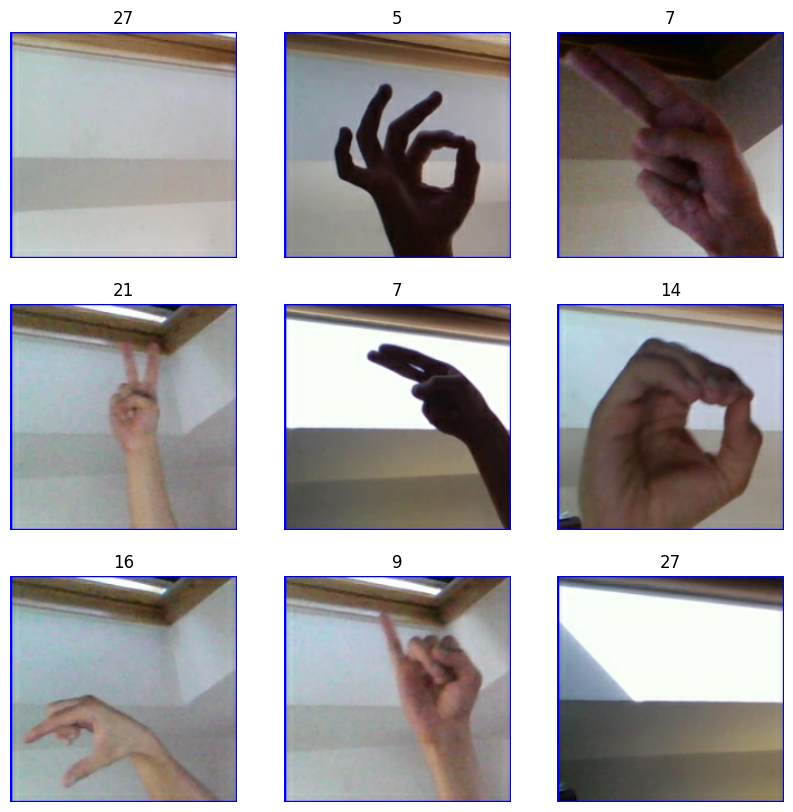

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
def create_augmentation_model():
    return Sequential([
        layers.RandomRotation(factor=(-0.15, 0.15)),
        layers.RandomZoom(height_factor=(-0.1, 0.1)),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomBrightness(factor=0.2),
        layers.RandomContrast(factor=0.2),
        layers.Rescaling(1./255)  # Normalisasi
    ])

def create_model(input_shape=(224, 224, 3), num_classes=29):
    # Definisikan arsitektur utama model
    model = Sequential([
        layers.Input(shape=input_shape),

        # Augmentasi dan preprocessing
        create_augmentation_model(),

        # Base model/feature extractor
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # Classifier head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [7]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = create_model()
    model.compile(
        optimizer=optimizers.AdamW(),
        loss=losses.SparseCategoricalCrossentropy(),
        metrics=[metrics.SparseCategoricalAccuracy()]
    )

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
]

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - loss: 3.2939 - sparse_categorical_accuracy: 0.0908
Epoch 1: val_loss improved from inf to 1.79851, saving model to best_model.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 125s 473ms/step - loss: 3.2924 - sparse_categorical_accuracy: 0.0910 - val_loss: 1.7985 - val_sparse_categorical_accuracy: 0.4671 - learning_rate: 0.0010
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - loss: 2.2054 - sparse_categorical_accuracy: 0.3171
Epoch 2: val_loss improved from 1.79851 to 1.11129, saving model to best_model.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 111s 464ms/step - loss: 2.2046 - sparse_categorical_accuracy: 0.3173 - val_loss: 1.1113 - val_sparse_categorical_accuracy: 0.6751 - learning_rate: 0.0010
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - loss: 1.6556 - sparse_categorical_accuracy: 0.4620
Epoch 3: val_loss improved from 1.11129 to 0.92780, saving model to best_model.keras
238/238 ━━━━━━━━━━━━━━━━━━━━ 111s 465ms/step - loss: 1.6553

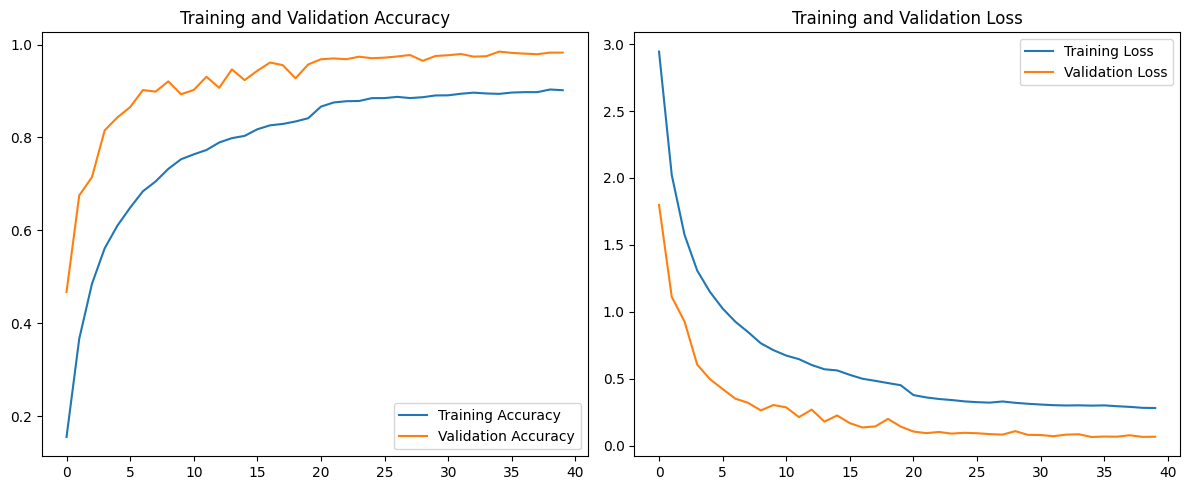

In [9]:
def plot_history(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

# Panggil fungsi
plot_history(history)

In [10]:
# Setelah training selesai, dan kamu load model terbaik dari .keras
model = tf.keras.models.load_model('best_model.keras')

test_loss, test_accuracy = model.evaluate(test_ds)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Simpan ke format SavedModel
model.export('saved_model/')  # ini valid di luar callback

34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - loss: 0.0568 - sparse_categorical_accuracy: 0.9864
Test Loss: 0.055782102048397064
Test Accuracy: 0.9870114922523499
Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  136858561625104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136858561844448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136858561852544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136858561927952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136858561933232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136858561927424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136858562029248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136858561850432: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [11]:
!zip -r "$(pwd)/saved_model.zip" "$(pwd)/saved_model"

  adding: kaggle/working/saved_model/ (stored 0%)
  adding: kaggle/working/saved_model/variables/ (stored 0%)
  adding: kaggle/working/saved_model/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: kaggle/working/saved_model/variables/variables.index (deflated 65%)
  adding: kaggle/working/saved_model/assets/ (stored 0%)
  adding: kaggle/working/saved_model/fingerprint.pb (stored 0%)
  adding: kaggle/working/saved_model/saved_model.pb (deflated 88%)
